<a href="https://colab.research.google.com/github/hjkwon-pknu/calculator/blob/main/Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## ML Pipeline
## Data Collecting -> Preprocessing -> Feature Engineering -> Data Splitting -> Modeling -> Deploy

In [2]:
# === Prep-Download: 1분봉 원본 CSV 생성 (BTCUSDT, Futures-UM, 1m, 2020-01-01~오늘) ===
import sys, os, subprocess, tempfile
from datetime import datetime
from zipfile import ZipFile
from os.path import join, exists, basename
from os import makedirs, walk, environ

def pip_install(p): subprocess.check_call([sys.executable, "-m", "pip", "install", p])

# deps
for p in ["GitPython","pandas","numpy","requests"]:
    try: __import__(p.split("==")[0])
    except: pip_install(p)

import pandas as pd, numpy as np
from git import Repo

STORE_PATH = "/content/binance_data"
os.makedirs(STORE_PATH, exist_ok=True)
environ["STORE_DIRECTORY"] = STORE_PATH

# clone binance public data (temp dir)
repo_url = "https://github.com/binance/binance-public-data.git"
temp_path = tempfile.mkdtemp(prefix="candle_download_")
Repo.clone_from(repo_url, temp_path)
WORK_PATH = temp_path

# install repo requirements
subprocess.check_call([sys.executable, "-m", "pip", "install", "-r", join(WORK_PATH, "python", "requirements.txt")])

# run download-kline.py (monthly + current month daily)
cmd = [sys.executable, join(WORK_PATH, "python", "download-kline.py")]
monthly = ["-t","um","-s","BTCUSDT","-i","1m","-skip-daily","1","-startDate","2020-01-01"]
daily   = ["-t","um","-s","BTCUSDT","-i","1m","-skip-monthly","1","-startDate", f"{datetime.utcnow().strftime('%Y-%m')}-01"]
subprocess.check_call(cmd + monthly)
subprocess.check_call(cmd + daily)

# unzip all downloaded zip files under STORE_PATH/data
def klines_unzip(search_directory=STORE_PATH):
    root_dir = join(search_directory, 'data')
    for root, _, files in walk(root_dir):
        for f in files:
            if f.endswith(".zip"):
                zpath = join(root, f)
                with ZipFile(zpath, 'r') as zf:
                    zf.extractall(root)
                print("unzipped:", zpath)

klines_unzip(STORE_PATH)

# merge all CSVs into a single 1m_history.csv
def klines_history(search_directory=STORE_PATH):
    search_directory = join(search_directory, 'data')
    history = pd.DataFrame()
    last_root = None
    for root, _, files in walk(search_directory):
        for f in sorted(files):
            if f.endswith(".csv") and f != f"{basename(root)}.csv":
                csv_path = join(root, f)
                with open(csv_path, "r") as fh:
                    first = fh.readline()
                if any(k in first for k in ["open_time","Open","open"]):
                    df = pd.read_csv(csv_path)
                else:
                    df = pd.read_csv(csv_path, header=None)
                    df.columns = ['open_time','open','high','low','close','volume','close_time',
                                  'quote_volume','count','taker_buy_volume','taker_buy_quote_volume','ignore']
                df = df.iloc[:, :6]
                df.columns = ['datetime','open','high','low','close','volume']
                history = pd.concat([history, df], ignore_index=True)
                last_root = root
    # de-dup, sort, save
    history['datetime'] = pd.to_datetime(history['datetime'], unit='ms', utc=True)
    history = history.sort_values('datetime').drop_duplicates('datetime')
    # keep ms integer for downstream
    history['datetime'] = (history['datetime'].view('int64') // 1_000_000).astype('int64')
    out_path = join(STORE_PATH, "1m_history.csv")
    history.to_csv(out_path, index=False)
    print("### Saved:", out_path, "rows:", len(history))
    return out_path

csv_path = klines_history(STORE_PATH)
print("READY:", csv_path)


/tmp/ipython-input-1636227599.py:34: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  daily   = ["-t","um","-s","BTCUSDT","-i","1m","-skip-monthly","1","-startDate", f"{datetime.utcnow().strftime('%Y-%m')}-01"]


unzipped: /content/binance_data/data/futures/um/daily/klines/BTCUSDT/1m/BTCUSDT-1m-2025-11-05.zip
unzipped: /content/binance_data/data/futures/um/daily/klines/BTCUSDT/1m/BTCUSDT-1m-2025-11-03.zip
unzipped: /content/binance_data/data/futures/um/daily/klines/BTCUSDT/1m/BTCUSDT-1m-2025-11-01.zip
unzipped: /content/binance_data/data/futures/um/daily/klines/BTCUSDT/1m/BTCUSDT-1m-2025-11-08.zip
unzipped: /content/binance_data/data/futures/um/daily/klines/BTCUSDT/1m/BTCUSDT-1m-2025-11-02.zip
unzipped: /content/binance_data/data/futures/um/daily/klines/BTCUSDT/1m/BTCUSDT-1m-2025-11-04.zip
unzipped: /content/binance_data/data/futures/um/daily/klines/BTCUSDT/1m/BTCUSDT-1m-2025-11-07.zip
unzipped: /content/binance_data/data/futures/um/daily/klines/BTCUSDT/1m/BTCUSDT-1m-2025-11-09.zip
unzipped: /content/binance_data/data/futures/um/daily/klines/BTCUSDT/1m/BTCUSDT-1m-2025-11-06.zip
unzipped: /content/binance_data/data/futures/um/daily/klines/BTCUSDT/1m/BTCUSDT-1m-2025-11-10.zip
unzipped: /content/b

/tmp/ipython-input-1636227599.py:76: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  history['datetime'] = (history['datetime'].view('int64') // 1_000_000).astype('int64')


### Saved: /content/binance_data/1m_history.csv rows: 3083040
READY: /content/binance_data/1m_history.csv


In [3]:
# 기본 셀 0
# ==== CONFIG ====
FILE_PATH   = "/content/binance_data/1m_history.csv"  # 기존과 동일 변수명
USE_ROWS    = None                                     # 필요시 800_000 등으로 tail 제한
TIMEFRAME   = "5T"                                     # "1T"(1분), "3T", "5T", "15T"... 중 택1
LOOKBACK    = 32                                       # 5분봉 기준 ~2h40m
H           = 3                                        # 라벨 예측 지평 (5m*3=15m 앞)
DEADZONE_Q  = 0.45                                     # 관망 비율(가운데 10%)
MODEL_TYPE  = "GRU"                                    # "GRU" 또는 "LSTM"
UNITS       = 64
EPOCHS      = 8
BATCH       = 1024
SEED        = 42

import os, gc, math, numpy as np, pandas as pd, random
random.seed(SEED); np.random.seed(SEED)

# 필수 라이브러리(이미 설치되어 있으면 import만)
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
tf.keras.utils.set_random_seed(SEED)

In [4]:
### 셀 A) 데이터 로드 + (선택) 리샘플
def load_data(path, use_rows=None):
    df = pd.read_csv(path, usecols=['datetime','open','high','low','close','volume'])
    if use_rows is not None and len(df) > use_rows:
        df = df.tail(use_rows).reset_index(drop=True)
    # 정렬 및 기본 전처리
    df = df.sort_values('datetime').reset_index(drop=True)
    return df

def _to_ts_index(df):
    dt = pd.to_datetime(df['datetime'], unit='ms', utc=True)
    ohlcv = df[['open','high','low','close','volume']].astype(float)
    ohlcv.index = dt
    return ohlcv.sort_index()

def resample_ohlcv(df_1m_ts, rule='5T'):
    o = df_1m_ts['open'].resample(rule).first()
    h = df_1m_ts['high'].resample(rule).max()
    l = df_1m_ts['low'].resample(rule).min()
    c = df_1m_ts['close'].resample(rule).last()
    v = df_1m_ts['volume'].resample(rule).sum()
    out = pd.concat([o,h,l,c,v], axis=1).dropna()
    out.columns = ['open','high','low','close','volume']
    out = out.reset_index()
    out.rename(columns={'index':'datetime'}, inplace=True)
    out['datetime'] = (out['datetime'].view('int64') // 1_000_000).astype('int64')  # UTC ms
    return out

# 실행
df_1m = load_data(FILE_PATH, USE_ROWS)
df_ts = _to_ts_index(df_1m)
df = resample_ohlcv(df_ts, TIMEFRAME) if TIMEFRAME != "1T" else df_1m.copy()
print("Data shape:", df.shape, "timeframe:", TIMEFRAME)


/tmp/ipython-input-3576236275.py:17: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  o = df_1m_ts['open'].resample(rule).first()
/tmp/ipython-input-3576236275.py:18: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  h = df_1m_ts['high'].resample(rule).max()
/tmp/ipython-input-3576236275.py:19: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  l = df_1m_ts['low'].resample(rule).min()
/tmp/ipython-input-3576236275.py:20: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  c = df_1m_ts['close'].resample(rule).last()
/tmp/ipython-input-3576236275.py:21: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  v = df_1m_ts['volume'].resample(rule).sum()


Data shape: (616608, 6) timeframe: 5T


/tmp/ipython-input-3576236275.py:26: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  out['datetime'] = (out['datetime'].view('int64') // 1_000_000).astype('int64')  # UTC ms


In [5]:
# 셀 B) 피처 & 라벨 (기존 make_features 이름 유지, 15개 피처 그대로)
def ema(s, span): return s.ewm(span=span, adjust=False).mean()
def rsi(close, n=14):
    d = close.diff()
    up = d.clip(lower=0).rolling(n).mean()
    dn = (-d.clip(upper=0)).rolling(n).mean()
    rs = up / (dn + 1e-12)
    return 100 - (100 / (1 + rs))
def atr_like(h,l,c,n=14):
    tr = (h - l).abs()
    return tr.rolling(n).mean()
def macd(c,f=12,s=26,sig=9):
    ef, es = ema(c,f), ema(c,s)
    line = ef - es; sigm = ema(line, sig); hist = line - sigm
    return line, sigm, hist

def make_features(df, h=3, deadzone_q=0.45):
    X = df.copy()
    # 15개 피처 (당신과 맞춘 목록)
    X['ret_1'] = X['close'].pct_change(1)
    X['ret_3'] = X['close'].pct_change(3)
    X['ret_5'] = X['close'].pct_change(5)
    X['hl_range'] = (X['high'] - X['low']) / X['close']
    X['rv_10'] = X['ret_1'].rolling(10).std() * np.sqrt(10)
    X['vol_chg'] = X['volume'].pct_change().replace([np.inf,-np.inf],0).fillna(0)
    X['z_close_50'] = (X['close'] / X['close'].rolling(50).mean()) - 1
    X['atr_14'] = atr_like(X['high'], X['low'], X['close'], 14)
    X['rsi_14'] = rsi(X['close'], 14)
    X['ema_20'] = ema(X['close'], 20)
    X['ema_50'] = ema(X['close'], 50)
    mline, msig, mhist = macd(X['close'])
    X['macd'], X['macd_sig'], X['macd_hist'] = mline, msig, mhist
    ma20 = X['close'].rolling(20).mean(); std20 = X['close'].rolling(20).std()
    X['bb_width'] = (2*std20) / (ma20 + 1e-12)

    # 3-클래스 라벨 원본(-1/0/1) + 이진(관망 제외)
    future_ret = X['close'].shift(-h) / X['close'] - 1
    lo, hi = future_ret.quantile(deadzone_q), future_ret.quantile(1-deadzone_q)
    y3_raw = np.where(future_ret > hi,  1,
               np.where(future_ret < lo, -1, 0))

    # 정리
    X = X.dropna().reset_index(drop=True)
    y3_raw = pd.Series(y3_raw).iloc[len(y3_raw)-len(X):].reset_index(drop=True)

    FEATS = ['ret_1','ret_3','ret_5','hl_range','rv_10','vol_chg','z_close_50','atr_14',
             'rsi_14','ema_20','ema_50','macd','macd_sig','macd_hist','bb_width']
    return X, FEATS, y3_raw  # y3_raw ∈ {-1,0,1}

# 실행
Xdf, FEATS, y3 = make_features(df, h=H, deadzone_q=DEADZONE_Q)
print(f"Features: {len(FEATS)}  rows: {len(Xdf)}  label dist:\n", pd.Series(y3).value_counts())


Features: 15  rows: 616559  label dist:
 -1    277457
 1    277446
 0     61656
Name: count, dtype: int64


In [6]:
### 셀 C) 스케일·시퀀스·분할
def time_split(df_like, test_ratio=0.2):
    n = len(df_like)
    split = int(n * (1 - test_ratio))
    train = (0, split)
    test  = (split, n)
    return train, test

def to_sequences(X_arr, y_arr, lookback, stride=1):
    Xs, ys = [], []
    for i in range(lookback, len(X_arr), stride):
        Xs.append(X_arr[i-lookback:i, :]); ys.append(y_arr[i])
    return np.array(Xs, np.float32), np.array(ys, np.int64)

def to_sequences_with_index(X_arr, y_arr, base_index, lookback, stride=1):
    Xs, ys, idxs = [], [], []
    for i in range(lookback, len(X_arr), stride):
        Xs.append(X_arr[i-lookback:i, :]); ys.append(y_arr[i]); idxs.append(base_index[i])
    return np.array(Xs, np.float32), np.array(ys, np.int64), np.array(idxs, np.int64)

# 관망 제외하고 이진 라벨로 변환(롱=1/숏=0)
mask = (y3 != 0)
X_used = Xdf.loc[mask, FEATS].copy()
y_bin  = (y3[mask] == 1).astype(int).values
base_idx = X_used.index.values

(train_s, train_e), (test_s, test_e) = time_split(X_used, test_ratio=0.2)
X_train_df, X_test_df = X_used.iloc[train_s:train_e], X_used.iloc[test_s:test_e]
y_train,   y_test     = y_bin[train_s:train_e],      y_bin[test_s:test_e]
base_idx_tr, base_idx_te = base_idx[train_s:train_e], base_idx[test_s:test_e]

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_df.values)
X_test_sc  = scaler.transform(X_test_df.values)

# 시퀀스 (stride=1; 빠른 결과 2~3)
X_tr_seq, y_tr_seq, idx_tr_seq = to_sequences_with_index(X_train_sc, y_train, base_idx_tr, LOOKBACK, stride=1)
X_te_seq, y_te_seq, idx_te_seq = to_sequences_with_index(X_test_sc,  y_test,  base_idx_te, LOOKBACK, stride=1)

# train→val
VAL_RATIO = 0.1
nv = int(len(X_tr_seq) * (1 - VAL_RATIO))
X_tr, X_val = X_tr_seq[:nv], X_tr_seq[nv:]
y_tr, y_val = y_tr_seq[:nv], y_tr_seq[nv:]
idx_val_seq = idx_tr_seq[nv:]

print("X_tr / X_val / X_te:", X_tr.shape, X_val.shape, X_te_seq.shape)
print("y dist train/val/test:",
      y_tr.mean().round(5), y_val.mean().round(5), y_te_seq.mean().round(5))


X_tr / X_val / X_te: (399501, 32, 15) (44389, 32, 15) (110949, 32, 15)
y dist train/val/test: 0.50077 0.49943 0.49741


In [7]:
### 셀 D) 모델 학습 (GRU/LSTM 선택 — build_model 새로 정의)

def build_model(model_type="GRU", units=64, lookback=32, n_feats=15, dropout=0.2, lr=1e-3):
    inp = layers.Input(shape=(lookback, n_feats))
    if model_type.upper() == "GRU":
        x = layers.Bidirectional(layers.GRU(units, return_sequences=False))(inp)
    else:
        x = layers.Bidirectional(layers.LSTM(units, return_sequences=False))(inp)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(64, activation='relu')(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inp, out)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

model = build_model(MODEL_TYPE, UNITS, LOOKBACK, len(FEATS), dropout=0.2, lr=1e-3)
cb = [
    callbacks.EarlyStopping(patience=2, monitor='val_auc', mode='max', restore_best_weights=True),
    callbacks.ReduceLROnPlateau(patience=1, factor=0.5, monitor='val_loss')
]
hist = model.fit(X_tr, y_tr, validation_data=(X_val, y_val),
                 epochs=EPOCHS, batch_size=BATCH, verbose=1, callbacks=cb)
print("Val AUC best:", max(hist.history.get('val_auc', [0])))

Epoch 1/8
391/391 ━━━━━━━━━━━━━━━━━━━━ 179s 439ms/step - accuracy: 0.5252 - auc: 0.5340 - loss: 0.6932 - val_accuracy: 0.5226 - val_auc: 0.5313 - val_loss: 0.6927 - learning_rate: 0.0010
Epoch 2/8
391/391 ━━━━━━━━━━━━━━━━━━━━ 176s 449ms/step - accuracy: 0.5355 - auc: 0.5486 - loss: 0.6897 - val_accuracy: 0.5207 - val_auc: 0.5299 - val_loss: 0.6929 - learning_rate: 0.0010
Epoch 3/8
391/391 ━━━━━━━━━━━━━━━━━━━━ 200s 445ms/step - accuracy: 0.5388 - auc: 0.5534 - loss: 0.6888 - val_accuracy: 0.5177 - val_auc: 0.5328 - val_loss: 0.6934 - learning_rate: 5.0000e-04
Epoch 4/8
391/391 ━━━━━━━━━━━━━━━━━━━━ 177s 453ms/step - accuracy: 0.5402 - auc: 0.5553 - loss: 0.6885 - val_accuracy: 0.5191 - val_auc: 0.5343 - val_loss: 0.6927 - learning_rate: 2.5000e-04
Epoch 5/8
391/391 ━━━━━━━━━━━━━━━━━━━━ 197s 503ms/step - accuracy: 0.5417 - auc: 0.5573 - loss: 0.6881 - val_accuracy: 0.5190 - val_auc: 0.5341 - val_loss: 0.6924 - learning_rate: 1.2500e-04
Epoch 6/8
391/391 ━━━━━━━━━━━━━━━━━━━━ 176s 449ms/ste

In [12]:
### 셀 E) 평가 + 임계값/방향 스캔
# 확률 예측
proba_val = model.predict(X_val, batch_size=4096).ravel()
proba_te  = model.predict(X_te_seq, batch_size=4096).ravel()

# 종가 시계열 슬라이스(인덱스 정합)
close_val = df.loc[idx_val_seq, 'close'].reset_index(drop=True)
close_te  = df.loc[idx_te_seq,  'close'].reset_index(drop=True)

def backtest_from_proba(proba, close, thr=0.55, fee_bps=6.0, invert=False, ann_scale_per_year=12*24*365):
    close = pd.Series(close).reset_index(drop=True)
    ret = close.pct_change().fillna(0).values
    sig = np.where(proba >= thr, 1, np.where(proba <= 1-thr, -1, 0))
    if invert: sig = -sig
    pos = np.roll(sig, 1); pos[0] = 0
    trades = (pos != np.roll(pos,1)).astype(int); trades[0] = (pos[0] != 0)
    cost = trades * (fee_bps/1e4)
    pnl = pos * ret - cost
    eq = (1 + pd.Series(pnl)).cumprod()
    sharpe = (pd.Series(pnl).mean() / (pd.Series(pnl).std()+1e-12)) * math.sqrt(ann_scale_per_year)
    mdd = ((eq - eq.cummax())/eq.cummax()).min()
    return {"trades": int(trades.sum()), "net_return": float(eq.iloc[-1]-1),
            "sharpe": float(sharpe), "max_drawdown": float(mdd), "final_equity": float(eq.iloc[-1])}

def scan_with_constraints(proba, close, fees=(4.0,6.0,8.0), thr_grid=(0.52,0.68,33),
                          invert_opts=(False,True), objective="sharpe", min_trades=15):
    lo, hi, n = thr_grid
    thrs = np.round(np.linspace(lo, hi, n), 3)
    best = None
    for inv in invert_opts:
        for f in fees:
            for t in thrs:
                m = backtest_from_proba(proba, close, thr=t, fee_bps=f, invert=inv,
                                        ann_scale_per_year=(12*24*365 if TIMEFRAME=='5T' else 365*24*60))
                if m["trades"] < min_trades:
                    continue
                score = m["sharpe"] if objective=="sharpe" else m["net_return"]
                if (best is None) or (score > best["score"]):
                    m.update({"thr": float(t), "fee_bps": float(f), "invert": inv, "score": float(score)})
                    best = m
    return best

best_val = scan_with_constraints(
    proba_val, close_val.values,
    fees=(4.0,6.0,8.0), thr_grid=(0.52,0.68,33),
    invert_opts=(False,True), objective="sharpe", min_trades=15
)
print("VAL best (constrained):", best_val)

bt = backtest_from_proba(
    proba_te, close_te.values,
    thr=best_val["thr"], fee_bps=best_val["fee_bps"], invert=best_val["invert"],
    ann_scale_per_year=(12*24*365 if TIMEFRAME=='5T' else 365*24*60)
)
print("TEST (apply VAL-opt):", bt)

#########

def backtest_from_proba_policy(proba, close, thr=0.60, fee_bps=4.0, invert=True,
                               cooldown=2, hold_min=1, max_trades=None,
                               ann_scale_per_year=12*24*365):
    import numpy as np, pandas as pd, math
    close = pd.Series(close).reset_index(drop=True)
    ret = close.pct_change().fillna(0).values

    sig = np.where(proba >= thr, 1, np.where(proba <= 1-thr, -1, 0))
    if invert: sig = -sig

    pos = np.zeros_like(sig)
    last_change = -1e9
    trades = 0
    for i in range(len(sig)):
        desired = sig[i]
        if i == 0:
            pos[i] = 0
            continue
        # 최소 보유 & 쿨다운
        if (i - last_change) < max(cooldown, hold_min):
            pos[i] = pos[i-1]
            continue
        # 포지션 변경은 신호가 0→±1 또는 ±1→∓1일 때만
        if desired != 0 and desired != pos[i-1]:
            pos[i] = desired
            last_change = i
            trades += 1
            if (max_trades is not None) and (trades >= max_trades):
                pos[i:] = pos[i]
                break
        else:
            pos[i] = pos[i-1]

    turn = (pos != np.roll(pos,1)).astype(int); turn[0]= (pos[0]!=0)
    cost = turn * (fee_bps/1e4)
    pnl = pos * ret - cost
    eq = (1 + pd.Series(pnl)).cumprod()
    sharpe = (pd.Series(pnl).mean() / (pd.Series(pnl).std() + 1e-12)) * math.sqrt(ann_scale_per_year)
    mdd = ((eq - eq.cummax())/eq.cummax()).min()
    return {"trades": int(turn.sum()), "net_return": float(eq.iloc[-1]-1),
            "sharpe": float(sharpe), "max_drawdown": float(mdd), "final_equity": float(eq.iloc[-1])}

11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 567ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 407ms/step
VAL best (constrained): {'trades': 18, 'net_return': 0.004748381199395357, 'sharpe': 0.5210229943998224, 'max_drawdown': -0.013810860411402708, 'final_equity': 1.0047483811993954, 'thr': 0.675, 'fee_bps': 4.0, 'invert': False, 'score': 0.5210229943998224}
TEST (apply VAL-opt): {'trades': 154, 'net_return': -0.034026870437435686, 'sharpe': -1.075851157864945, 'max_drawdown': -0.038779597897476356, 'final_equity': 0.9659731295625643}


In [13]:
import numpy as np

def scan_policy(proba, close, fees=(4.0,6.0), thr_range=(0.58,0.62,41),
                invert_opts=(True, False), cooldown=2, hold_min=1,
                min_trades=12, max_trades=150):
    lo, hi, n = thr_range
    thrs = np.round(np.linspace(lo, hi, n), 3)
    best=None
    for inv in invert_opts:
        for f in fees:
            for t in thrs:
                m = backtest_from_proba_policy(proba, close, thr=t, fee_bps=f, invert=inv,
                                               cooldown=cooldown, hold_min=hold_min, max_trades=max_trades)
                if m["trades"] < min_trades:
                    continue
                score = m["sharpe"]
                if (best is None) or (score > best["score"]):
                    m.update({"thr": float(t), "fee_bps": float(f), "invert": inv, "score": float(score)})
                    best = m
    return best

# 검증에서 고정
best_val_policy = scan_policy(proba_val, close_val.values,
                              fees=(4.0,6.0), thr_range=(0.58,0.62,41),
                              invert_opts=(True, False), cooldown=2, hold_min=1,
                              min_trades=20, max_trades=120)
print("VAL best (policy):", best_val_policy)

# 테스트에 적용
bt_policy = backtest_from_proba_policy(proba_te, close_te.values,
                                       thr=best_val_policy["thr"],
                                       fee_bps=best_val_policy["fee_bps"],
                                       invert=best_val_policy["invert"],
                                       cooldown=2, hold_min=1, max_trades=120)
print("TEST (policy apply):", bt_policy)

VAL best (policy): {'trades': 120, 'net_return': 2.1664076795494434, 'sharpe': 5.025194894892772, 'max_drawdown': -0.25898933472314134, 'final_equity': 3.1664076795494434, 'thr': 0.593, 'fee_bps': 4.0, 'invert': True, 'score': 5.025194894892772}
TEST (policy apply): {'trades': 120, 'net_return': 0.3701736216591973, 'sharpe': 0.8515853707443658, 'max_drawdown': -0.4966236628671078, 'final_equity': 1.3701736216591973}


In [14]:
## 민감도 조절
# thr 주변 ±0.004, fee 4/6/8bp 민감도
for thr in [round(0.593+d,3) for d in [-0.004,-0.002,0,0.002,0.004]]:
    for fee in (4.0,6.0,8.0):
        m = backtest_from_proba_policy(
            proba_te, close_te.values,
            thr=thr, fee_bps=fee, invert=True,
            cooldown=2, hold_min=1, max_trades=120
        )
        print(f"thr={thr:.3f} fee={fee:.0f}bp -> net={m['net_return']:.3f} sharpe={m['sharpe']:.2f} MDD={m['max_drawdown']:.3f} trades={m['trades']}")

thr=0.589 fee=4bp -> net=0.562 sharpe=1.10 MDD=-0.443 trades=120
thr=0.589 fee=6bp -> net=0.525 sharpe=1.06 MDD=-0.443 trades=120
thr=0.589 fee=8bp -> net=0.489 sharpe=1.01 MDD=-0.443 trades=120
thr=0.591 fee=4bp -> net=0.389 sharpe=0.88 MDD=-0.481 trades=120
thr=0.591 fee=6bp -> net=0.356 sharpe=0.83 MDD=-0.485 trades=120
thr=0.591 fee=8bp -> net=0.324 sharpe=0.79 MDD=-0.490 trades=120
thr=0.593 fee=4bp -> net=0.370 sharpe=0.85 MDD=-0.497 trades=120
thr=0.593 fee=6bp -> net=0.338 sharpe=0.81 MDD=-0.502 trades=120
thr=0.593 fee=8bp -> net=0.306 sharpe=0.76 MDD=-0.508 trades=120
thr=0.595 fee=4bp -> net=0.494 sharpe=1.02 MDD=-0.445 trades=120
thr=0.595 fee=6bp -> net=0.459 sharpe=0.97 MDD=-0.451 trades=120
thr=0.595 fee=8bp -> net=0.424 sharpe=0.93 MDD=-0.457 trades=120
thr=0.597 fee=4bp -> net=0.617 sharpe=1.17 MDD=-0.443 trades=120
thr=0.597 fee=6bp -> net=0.579 sharpe=1.12 MDD=-0.443 trades=120
thr=0.597 fee=8bp -> net=0.542 sharpe=1.08 MDD=-0.443 trades=120


In [15]:
### 과매매 억제
for cd in (2,3,4):           # cooldown
    for cap in (120,100,90): # max_trades
        m = backtest_from_proba_policy(
            proba_te, close_te.values,
            thr=0.593, fee_bps=4.0, invert=True,
            cooldown=cd, hold_min=2, max_trades=cap
        )
        print(f"cd={cd} cap={cap} -> net={m['net_return']:.3f} sharpe={m['sharpe']:.2f} MDD={m['max_drawdown']:.3f} trades={m['trades']}")

cd=2 cap=120 -> net=0.370 sharpe=0.85 MDD=-0.497 trades=120
cd=2 cap=100 -> net=0.523 sharpe=1.05 MDD=-0.443 trades=100
cd=2 cap=90 -> net=0.704 sharpe=1.27 MDD=-0.443 trades=90
cd=3 cap=120 -> net=0.370 sharpe=0.85 MDD=-0.497 trades=120
cd=3 cap=100 -> net=0.523 sharpe=1.05 MDD=-0.443 trades=100
cd=3 cap=90 -> net=0.704 sharpe=1.27 MDD=-0.443 trades=90
cd=4 cap=120 -> net=0.382 sharpe=0.87 MDD=-0.497 trades=120
cd=4 cap=100 -> net=0.536 sharpe=1.07 MDD=-0.443 trades=100
cd=4 cap=90 -> net=0.719 sharpe=1.29 MDD=-0.443 trades=90


In [17]:
# # ATR(14) 계산 (검증/테스트 인덱스에 맞춰 슬라이스)
# hi_te = df.loc[idx_te_seq, 'high'].reset_index(drop=True)
# lo_te = df.loc[idx_te_seq, 'low' ].reset_index(drop=True)
# cl_te = df.loc[idx_te_seq, 'close'].reset_index(drop=True)
# atr14 = (hi_te - lo_te).rolling(14).mean().fillna(method='bfill').values

# def backtest_policy_sl(
#     proba, close, atr, thr=0.593, fee_bps=4.0, invert=True,
#     cooldown=2, hold_min=2, max_trades=100, sl_k=1.5, tp_k=None
# ):
#     import numpy as np, pandas as pd, math
#     close = pd.Series(close).reset_index(drop=True).values
#     ret = pd.Series(close).pct_change().fillna(0).values
#     sig = np.where(proba >= thr, 1, np.where(proba <= 1-thr, -1, 0))
#     if invert: sig = -sig

#     pos = 0; entry = None; trades=0
#     pnl = np.zeros_like(ret)
#     last_change = -10**9

#     for i in range(1, len(ret)):
#         desired = sig[i]
#         # 유지
#         if (i - last_change) < max(cooldown, hold_min):
#             pass
#         else:
#             if desired != 0 and desired != pos:
#                 # 진입/반전
#                 pnl[i] -= (fee_bps/1e4)  # 체결 비용
#                 pos = desired
#                 entry = close[i]
#                 last_change = i
#                 trades += 1

#         # SL/TP 체크
#         if pos != 0 and entry is not None:
#             move = (close[i] - entry)/entry
#             move = move if pos==1 else -move
#             if sl_k is not None and move <= -(sl_k * (atr[i]/entry)):
#                 pnl[i] -= (fee_bps/1e4)  # 청산 비용
#                 pos = 0; entry=None; last_change = i
#             elif tp_k is not None and move >= (tp_k * (atr[i]/entry)):
#                 pnl[i] -= (fee_bps/1e4)
#                 pos = 0; entry=None; last_change = i

#         pnl[i] += pos * ret[i]

#     eq = (1 + pd.Series(pnl)).cumprod()
#     sharpe = (pd.Series(pnl).mean()/(pd.Series(pnl).std()+1e-12))*np.sqrt(12*24*365)
#     mdd = ((eq - eq.cummax())/eq.cummax()).min()
#     return {"trades": trades, "net_return": float(eq.iloc[-1]-1),
#             "sharpe": float(sharpe), "max_drawdown": float(mdd)}

# for sl in (1.0, 1.5, 2.0):
#     m = backtest_policy_sl(proba_te, close_te.values, atr14,
#                            thr=0.593, fee_bps=4.0, invert=True,
#                            cooldown=3, hold_min=2, max_trades=100, sl_k=sl, tp_k=None)
#     print(f"SL={sl}*ATR -> net={m['net_return']:.3f} sharpe={m['sharpe']:.2f} MDD={m['max_drawdown']:.3f} trades={m['trades']}")

def backtest_policy_sl_fixed(
    proba, close, high, low,                       # 시계열
    thr=0.597, fee_bps=4.0, invert=True,
    cooldown=3, hold_min=2, max_trades=100,
    sl_k=1.5, tp_k=None,                           # SL/TP = k * ATR(14)
    ann_scale_per_year=12*24*365
):
    import numpy as np, pandas as pd, math

    # 입력 정리
    close = pd.Series(close).reset_index(drop=True).astype(float).values
    high  = pd.Series(high ).reset_index(drop=True).astype(float).values
    low   = pd.Series(low  ).reset_index(drop=True).astype(float).values

    # ATR(14) close-only 대체보단 고/저 사용이 낫습니다.
    tr  = np.maximum.reduce([high - low,
                             np.abs(high - np.roll(close, 1)),
                             np.abs(low  - np.roll(close, 1))])
    tr[0] = high[0] - low[0]
    atr  = pd.Series(tr).rolling(14).mean().bfill().values

    # 신호
    sig = np.where(proba >= thr, 1, np.where(proba <= 1-thr, -1, 0))
    if invert: sig = -sig

    pos = 0            # -1 / 0 / +1
    entry_price = None
    last_change  = -10**9
    trades = 0

    ret = pd.Series(close).pct_change().fillna(0).values
    pnl = np.zeros_like(ret)

    for i in range(1, len(ret)):
        # 기본 유지
        desired = sig[i]

        # 쿨다운/최소보유 동안은 포지션 고정
        if (i - last_change) < max(cooldown, hold_min):
            # 보유 중이면 SL/TP만 체크
            if pos != 0 and entry_price is not None:
                move = (close[i] - entry_price) / entry_price
                move = move if pos == 1 else -move
                # SL
                if sl_k is not None and move <= -(sl_k * (atr[i] / entry_price)):
                    pnl[i] -= (fee_bps / 1e4)
                    pos = 0; entry_price = None; last_change = i
                # TP
                elif tp_k is not None and move >=  (tp_k * (atr[i] / entry_price)):
                    pnl[i] -= (fee_bps / 1e4)
                    pos = 0; entry_price = None; last_change = i

            pnl[i] += pos * ret[i]
            continue

        # 진입/반전 (다음 봉에서만 허용)
        changed = False
        if desired != 0 and desired != pos:
            if (max_trades is None) or (trades < max_trades):
                pnl[i] -= (fee_bps / 1e4)      # 진입 비용
                pos = desired
                entry_price = close[i]
                last_change = i
                trades += 1
                changed = True

        # SL/TP 체크 (진입과 같은 봉에서는 SL/TP 미체크 → 다음 봉부터)
        if (not changed) and pos != 0 and entry_price is not None:
            move = (close[i] - entry_price) / entry_price
            move = move if pos == 1 else -move
            if sl_k is not None and move <= -(sl_k * (atr[i] / entry_price)):
                pnl[i] -= (fee_bps / 1e4)      # 청산 비용
                pos = 0; entry_price = None; last_change = i
            elif tp_k is not None and move >=  (tp_k * (atr[i] / entry_price)):
                pnl[i] -= (fee_bps / 1e4)
                pos = 0; entry_price = None; last_change = i

        pnl[i] += pos * ret[i]

    eq = (1 + pd.Series(pnl)).cumprod()
    sharpe = (pd.Series(pnl).mean()/(pd.Series(pnl).std()+1e-12)) * math.sqrt(ann_scale_per_year)
    mdd = ((eq - eq.cummax())/eq.cummax()).min()

    return {"trades": trades, "net_return": float(eq.iloc[-1]-1),
            "sharpe": float(sharpe), "max_drawdown": float(mdd)}

In [18]:
hi_te = df.loc[idx_te_seq, 'high'].reset_index(drop=True)
lo_te = df.loc[idx_te_seq, 'low' ].reset_index(drop=True)
cl_te = df.loc[idx_te_seq, 'close'].reset_index(drop=True)

for sl in (1.0, 1.5, 2.0):
    for tp in (None, 2.0, 3.0):
        for cap in (90, 100, 120):
            m = backtest_policy_sl_fixed(
                proba_te, cl_te.values, hi_te.values, lo_te.values,
                thr=0.597, fee_bps=4.0, invert=True,
                cooldown=3, hold_min=2, max_trades=cap,
                sl_k=sl, tp_k=tp
            )
            print(f"SL={sl} TP={tp} cap={cap} -> net={m['net_return']:.3f} "
                  f"sharpe={m['sharpe']:.2f} MDD={m['max_drawdown']:.3f} trades={m['trades']}")

SL=1.0 TP=None cap=90 -> net=1.060 sharpe=4.08 MDD=-0.067 trades=90
SL=1.0 TP=None cap=100 -> net=1.343 sharpe=4.56 MDD=-0.067 trades=100
SL=1.0 TP=None cap=120 -> net=1.403 sharpe=4.51 MDD=-0.067 trades=120
SL=1.0 TP=2.0 cap=90 -> net=0.054 sharpe=1.54 MDD=-0.015 trades=90
SL=1.0 TP=2.0 cap=100 -> net=0.054 sharpe=1.48 MDD=-0.015 trades=100
SL=1.0 TP=2.0 cap=120 -> net=0.038 sharpe=0.99 MDD=-0.019 trades=120
SL=1.0 TP=3.0 cap=90 -> net=0.139 sharpe=2.82 MDD=-0.016 trades=90
SL=1.0 TP=3.0 cap=100 -> net=0.141 sharpe=2.76 MDD=-0.016 trades=100
SL=1.0 TP=3.0 cap=120 -> net=0.133 sharpe=2.48 MDD=-0.019 trades=120
SL=1.5 TP=None cap=90 -> net=1.457 sharpe=4.29 MDD=-0.084 trades=90
SL=1.5 TP=None cap=100 -> net=1.429 sharpe=4.49 MDD=-0.067 trades=100
SL=1.5 TP=None cap=120 -> net=1.603 sharpe=4.59 MDD=-0.067 trades=120
SL=1.5 TP=2.0 cap=90 -> net=0.051 sharpe=1.25 MDD=-0.021 trades=90
SL=1.5 TP=2.0 cap=100 -> net=0.054 sharpe=1.27 MDD=-0.021 trades=100
SL=1.5 TP=2.0 cap=120 -> net=0.039 sha

In [19]:
# 준비 (VAL 구간 시계열)
hi_val = df.loc[idx_val_seq, 'high'].reset_index(drop=True).values
lo_val = df.loc[idx_val_seq, 'low' ].reset_index(drop=True).values
cl_val = df.loc[idx_val_seq, 'close'].reset_index(drop=True).values

def eval_policy_sl_fixed(proba, close, high, low, sl_list=(1.0,1.5,2.0), caps=(90,100,120),
                         thr=0.597, fee=4.0, invert=True, cooldown=3, hold_min=2, tp=None,
                         min_trades=60, mdd_floor=-0.20):
    best=None
    for sl in sl_list:
        for cap in caps:
            m = backtest_policy_sl_fixed(proba, close, high, low,
                                         thr=thr, fee_bps=fee, invert=invert,
                                         cooldown=cooldown, hold_min=hold_min, max_trades=cap,
                                         sl_k=sl, tp_k=tp)
            if m["trades"] < min_trades or m["max_drawdown"] < mdd_floor:  # 너무 적거나 MDD 과다면 제외
                continue
            score = m["sharpe"]
            if (best is None) or (score > best["score"]):
                m.update({"sl":sl, "cap":cap, "tp":tp, "score":score})
                best=m
    return best

# 1) VAL에서 고름
best_val_policy = eval_policy_sl_fixed(proba_val, cl_val, hi_val, lo_val,
                                       sl_list=(1.0,1.5,2.0), caps=(90,100,120),
                                       thr=0.597, fee=4.0, invert=True, cooldown=3, hold_min=2,
                                       tp=None, min_trades=60, mdd_floor=-0.20)
print("VAL choice:", best_val_policy)

# 2) TEST에 그대로 적용
hi_te = df.loc[idx_te_seq, 'high'].reset_index(drop=True).values
lo_te = df.loc[idx_te_seq, 'low' ].reset_index(drop=True).values
cl_te = df.loc[idx_te_seq, 'close'].reset_index(drop=True).values

final_test = backtest_policy_sl_fixed(proba_te, cl_te, hi_te, lo_te,
                                      thr=0.597, fee_bps=4.0, invert=True,
                                      cooldown=3, hold_min=2, max_trades=best_val_policy["cap"],
                                      sl_k=best_val_policy["sl"], tp_k=best_val_policy["tp"])
print("TEST with VAL-opt:", final_test)

VAL choice: {'trades': 120, 'net_return': 1.4290126558774547, 'sharpe': 6.504561501645909, 'max_drawdown': -0.08121248909237408, 'sl': 2.0, 'cap': 120, 'tp': None, 'score': 6.504561501645909}
TEST with VAL-opt: {'trades': 120, 'net_return': 1.5510914859797507, 'sharpe': 4.24618536521115, 'max_drawdown': -0.06662144644418193}


In [21]:
# === F0: 정책 백테스트 (numpy-only 교정본) ===
import numpy as np, pandas as pd, math

def backtest_policy_sl_fixed(
    proba, close, high, low,
    thr=0.597, fee_bps=4.0, invert=True,
    cooldown=3, hold_min=2, max_trades=100,
    sl_k=2.0, tp_k=None,
    ann_scale_per_year=12*24*365
):
    proba = np.asarray(proba, dtype=float).ravel()
    close = np.asarray(close, dtype=float).ravel()
    high  = np.asarray(high,  dtype=float).ravel()
    low   = np.asarray(low,   dtype=float).ravel()

    prev_close = np.concatenate(([close[0]], close[:-1]))
    tr = np.maximum.reduce([
        high - low,
        np.abs(high - prev_close),
        np.abs(low  - prev_close)
    ])
    atr = pd.Series(tr).rolling(14).mean().bfill().to_numpy()

    sig = np.where(proba >= thr, 1, np.where(proba <= 1-thr, -1, 0))
    if invert: sig = -sig

    ret = np.zeros_like(close)
    ret[1:] = (close[1:] - close[:-1]) / close[:-1]

    pos = 0; entry = None; last_change = -10**9; trades = 0
    pnl = np.zeros_like(ret, dtype=float)

    for i in range(1, len(ret)):
        desired = sig[i]

        if (i - last_change) < max(cooldown, hold_min):
            if pos != 0 and entry is not None:
                move = (close[i] - entry) / entry
                if pos == -1: move = -move
                if (sl_k is not None) and (move <= -(sl_k * (atr[i] / entry))):
                    pnl[i] -= (fee_bps/1e4); pos = 0; entry = None; last_change = i
                elif (tp_k is not None) and (move >=  (tp_k * (atr[i] / entry))):
                    pnl[i] -= (fee_bps/1e4); pos = 0; entry = None; last_change = i
            pnl[i] += pos * ret[i]
            continue

        changed = False
        if desired != 0 and desired != pos:
            if (max_trades is None) or (trades < max_trades):
                pnl[i] -= (fee_bps/1e4)
                pos = desired; entry = close[i]; last_change = i; trades += 1; changed = True

        if (not changed) and pos != 0 and entry is not None:
            move = (close[i] - entry) / entry
            if pos == -1: move = -move
            if (sl_k is not None) and (move <= -(sl_k * (atr[i] / entry))):
                pnl[i] -= (fee_bps/1e4); pos = 0; entry = None; last_change = i
            elif (tp_k is not None) and (move >=  (tp_k * (atr[i] / entry))):
                pnl[i] -= (fee_bps/1e4); pos = 0; entry = None; last_change = i

        pnl[i] += pos * ret[i]

    eq = (1 + pd.Series(pnl)).cumprod()
    sharpe = (pd.Series(pnl).mean() / (pd.Series(pnl).std() + 1e-12)) * math.sqrt(ann_scale_per_year)
    mdd = ((eq - eq.cummax())/eq.cummax()).min()
    return {"trades": trades, "net_return": float(eq.iloc[-1]-1),
            "sharpe": float(sharpe), "max_drawdown": float(mdd)}

def run_policy_path(
    proba, close, high, low,
    thr=0.597, invert=True, cooldown=3, hold_min=2, cap=120,
    sl_k=2.0, tp_k=None, fee_bps=4.0
):
    proba = np.asarray(proba, dtype=float).ravel()
    close = np.asarray(close, dtype=float).ravel()
    high  = np.asarray(high,  dtype=float).ravel()
    low   = np.asarray(low,   dtype=float).ravel()

    prev_close = np.concatenate(([close[0]], close[:-1]))
    tr = np.maximum.reduce([
        high - low,
        np.abs(high - prev_close),
        np.abs(low  - prev_close)
    ])
    atr = pd.Series(tr).rolling(14).mean().bfill().to_numpy()

    sig = np.where(proba >= thr, 1, np.where(proba <= 1-thr, -1, 0))
    if invert: sig = -sig

    ret = np.zeros_like(close); ret[1:] = (close[1:] - close[:-1]) / close[:-1]

    pos=0; entry=None; last=-10**9; trades=0
    pnl = np.zeros_like(ret, dtype=float); pos_arr = np.zeros_like(ret, dtype=int)

    for i in range(1, len(ret)):
        desired = sig[i]
        if (i - last) < max(cooldown, hold_min):
            if pos!=0 and entry is not None:
                move = (close[i] - entry)/entry
                if pos==-1: move = -move
                if (sl_k is not None) and (move <= -(sl_k * (atr[i]/entry))):
                    pnl[i] -= (fee_bps/1e4); pos=0; entry=None; last=i
                elif (tp_k is not None) and (move >=  (tp_k * (atr[i]/entry))):
                    pnl[i] -= (fee_bps/1e4); pos=0; entry=None; last=i
            pnl[i] += pos * ret[i]; pos_arr[i]=pos; continue

        changed=False
        if desired!=0 and desired!=pos and (trades < cap):
            pnl[i] -= (fee_bps/1e4)
            pos=desired; entry=close[i]; last=i; trades+=1; changed=True

        if (not changed) and pos!=0 and entry is not None:
            move = (close[i] - entry)/entry
            if pos==-1: move = -move
            if (sl_k is not None) and (move <= -(sl_k * (atr[i]/entry))):
                pnl[i] -= (fee_bps/1e4); pos=0; entry=None; last=i
            elif (tp_k is not None) and (move >=  (tp_k * (atr[i]/entry))):
                pnl[i] -= (fee_bps/1e4); pos=0; entry=None; last=i

        pnl[i] += pos * ret[i]; pos_arr[i]=pos

    eq = (1 + pd.Series(pnl)).cumprod(); dd = (eq/eq.cummax()) - 1
    return pd.DataFrame({
        "close": close, "proba": proba, "position": pos_arr,
        "ret": ret, "pnl": pnl, "equity": eq.values, "drawdown": dd.values
    })


In [22]:
# === F1: VAL에서 SL/cap 선택 → TEST 적용 ===
# VAL/TEST 시계열 준비
hi_val = df.loc[idx_val_seq, 'high'].reset_index(drop=True).values
lo_val = df.loc[idx_val_seq, 'low' ].reset_index(drop=True).values
cl_val = df.loc[idx_val_seq, 'close'].reset_index(drop=True).values

hi_te = df.loc[idx_te_seq, 'high'].reset_index(drop=True).values
lo_te = df.loc[idx_te_seq, 'low' ].reset_index(drop=True).values
cl_te = df.loc[idx_te_seq, 'close'].reset_index(drop=True).values

def eval_policy_sl_fixed(proba, close, high, low,
                         sl_list=(1.0,1.5,2.0), caps=(90,100,120),
                         thr=0.597, fee=4.0, invert=True,
                         cooldown=3, hold_min=2, tp=None,
                         min_trades=60, mdd_floor=-0.20):
    best=None
    for sl in sl_list:
        for cap in caps:
            m = backtest_policy_sl_fixed(
                proba, close, high, low,
                thr=thr, fee_bps=fee, invert=invert,
                cooldown=cooldown, hold_min=hold_min, max_trades=cap,
                sl_k=sl, tp_k=tp
            )
            if m["trades"] < min_trades or m["max_drawdown"] < mdd_floor:
                continue
            score = m["sharpe"]
            if (best is None) or (score > best["score"]):
                m.update({"sl":sl, "cap":cap, "tp":tp, "score":score})
                best = m
    return best

# 1) VAL에서 최적 정책 선택
val_choice = eval_policy_sl_fixed(
    proba_val, cl_val, hi_val, lo_val,
    sl_list=(1.0,1.5,2.0), caps=(90,100,120),
    thr=0.597, fee=4.0, invert=True,
    cooldown=3, hold_min=2, tp=None, min_trades=60, mdd_floor=-0.20
)
print("VAL choice:", val_choice)

# 2) TEST에 그대로 적용
test_final = backtest_policy_sl_fixed(
    proba_te, cl_te, hi_te, lo_te,
    thr=0.597, fee_bps=4.0, invert=True,
    cooldown=3, hold_min=2, max_trades=val_choice["cap"],
    sl_k=val_choice["sl"], tp_k=val_choice["tp"]
)
print("TEST with VAL-opt:", test_final)

VAL choice: {'trades': 120, 'net_return': 1.4290126558774467, 'sharpe': 6.504561501645863, 'max_drawdown': -0.08121248909237556, 'sl': 2.0, 'cap': 120, 'tp': None, 'score': 6.504561501645863}
TEST with VAL-opt: {'trades': 120, 'net_return': 1.5510914859797538, 'sharpe': 4.246185365211184, 'max_drawdown': -0.06662144644418046}


Saved: /content/runs 
TEST summary: {'net_return': 1.5510914859797538, 'sharpe': 4.246185365211184, 'max_drawdown': -0.06662144644418044, 'trades': 186}
Figures saved: equity_vs_bh.png, drawdown.png, price_entries.png


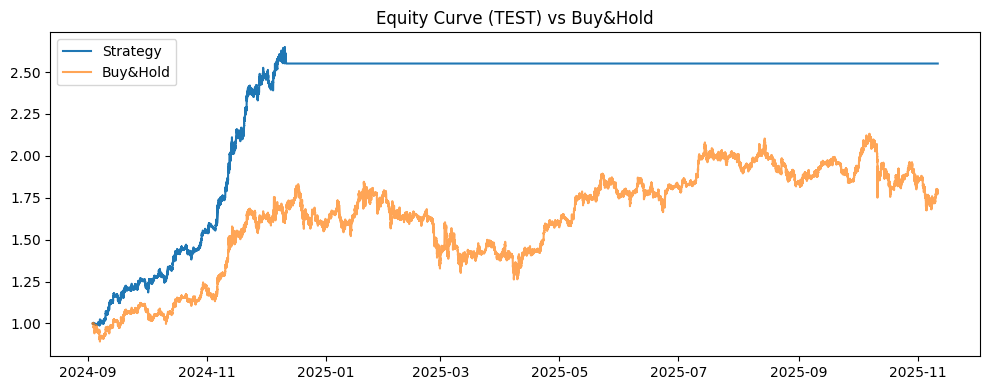

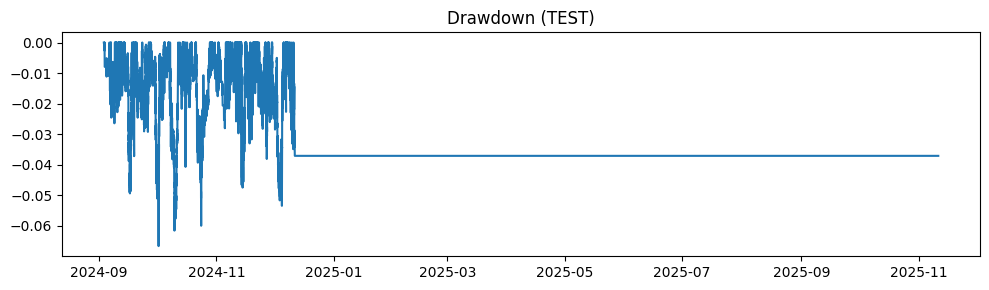

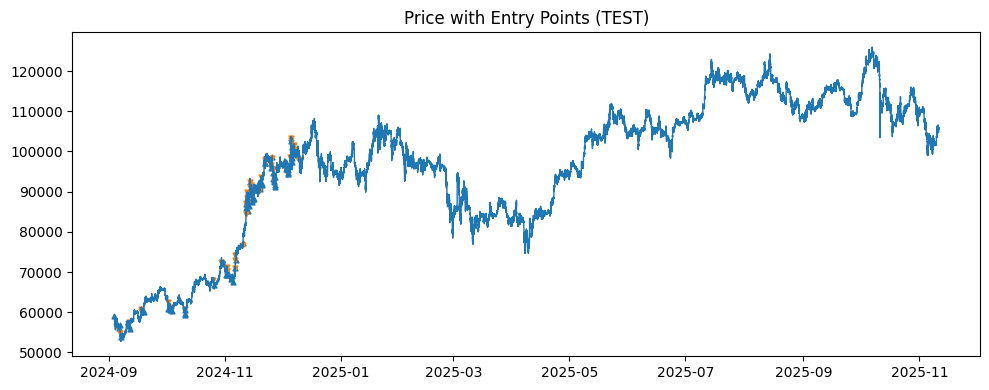

In [25]:
# === G1: TEST 리포트 산출 (그래프/CSV/요약) ===
import json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

# 최종 설정 (F1 출력값과 동일하게 맞춰주세요)
FINAL = {
    "timeframe": "5m",
    "model": "GRU(64)",
    "lookback": 32,
    "label": {"H": 3, "deadzone_q": 0.45},
    "decision": {"invert": True, "thr": 0.597},
    "risk": {"cooldown": 3, "hold_min": 2, "SL_ATR": 2.0, "TP": None, "cap": 120},
    "fees_bps": 4.0
}

# --- 수정된 TEST 구간 시계열 (길이 정합 보장) ---
sel = df.iloc[idx_te_seq].reset_index(drop=True)

ts_te = pd.to_datetime(sel["datetime"], unit="ms", utc=True).dt.tz_convert("Asia/Seoul")
cl_te = sel["close"].astype(float).values
hi_te = sel["high"].astype(float).values
lo_te = sel["low"].astype(float).values

# # 테스트 구간 시계열
# ts_te = pd.to_datetime(
#     df.loc[idx_te_seq, 'datetime'].reset_index(drop=True),
#     unit='ms', utc=True
# ).dt.tz_convert('Asia/Seoul')
# cl_te = df.loc[idx_te_seq, 'close'].reset_index(drop=True).astype(float).values
# hi_te = df.loc[idx_te_seq, 'high' ].reset_index(drop=True).astype(float).values
# lo_te = df.loc[idx_te_seq, 'low'  ].reset_index(drop=True).astype(float).values

# 정책 경로 로그 (포지션/에쿼티/드로다운)
log = run_policy_path(
    proba_te, cl_te, hi_te, lo_te,
    thr=FINAL["decision"]["thr"], invert=FINAL["decision"]["invert"],
    cooldown=FINAL["risk"]["cooldown"], hold_min=FINAL["risk"]["hold_min"],
    cap=FINAL["risk"]["cap"], sl_k=FINAL["risk"]["SL_ATR"], tp_k=FINAL["risk"]["TP"],
    fee_bps=FINAL["fees_bps"]
)
log.insert(0, "datetime", ts_te.values)

# 트레이드 로그(포지션 변화 지점만)
turn = (log["position"].values != np.roll(log["position"].values, 1))
turn[0] = (log["position"].values[0] != 0)
trades = log.loc[turn, ["datetime", "close", "position"]].copy()
trades["side"] = trades["position"].map({1:"LONG", -1:"SHORT", 0:"FLAT"})

# Buy&Hold 비교 (동일 구간 시작=1.0 기준)
bh_equity = (cl_te / cl_te[0])
eq_series = log["equity"].values
dd_series = log["drawdown"].values

# 출력 폴더 및 저장
OUT = Path("/content/runs"); OUT.mkdir(parents=True, exist_ok=True)
log.to_csv(OUT/"trades_log_test.csv", index=False)
trades.to_csv(OUT/"trades_points_test.csv", index=False)
with open(OUT/"final_config.json", "w") as f: json.dump(FINAL, f, indent=2, ensure_ascii=False)

# 요약 지표
summary = {
    "TEST": {
        "net_return": float(eq_series[-1]-1),
        "sharpe": float(((log["pnl"].mean())/(log["pnl"].std()+1e-12))*np.sqrt(12*24*365)),
        "max_drawdown": float(dd_series.min()),
        "trades": int((turn).sum())
    }
}
with open(OUT/"summary.json", "w") as f: json.dump(summary, f, indent=2)
print("Saved:", OUT, "\nTEST summary:", summary["TEST"])

# --- 플롯: 에쿼티/드로다운/매매포인트 ---
plt.figure(figsize=(10,4))
plt.plot(ts_te, eq_series, label="Strategy")
plt.plot(ts_te, bh_equity, label="Buy&Hold", alpha=0.7)
plt.title("Equity Curve (TEST) vs Buy&Hold")
plt.legend(); plt.tight_layout()
plt.savefig(OUT/"equity_vs_bh.png", dpi=150)

plt.figure(figsize=(10,3))
plt.plot(ts_te, dd_series)
plt.title("Drawdown (TEST)")
plt.tight_layout()
plt.savefig(OUT/"drawdown.png", dpi=150)

# 가격 + 진입 포인트(간단 표시)
buy_pts  = trades[trades["position"]== 1]
sell_pts = trades[trades["position"]==-1]
plt.figure(figsize=(10,4))
plt.plot(ts_te, cl_te, linewidth=1)
plt.scatter(buy_pts["datetime"],  buy_pts["close"],  s=12, marker="^")
plt.scatter(sell_pts["datetime"], sell_pts["close"], s=12, marker="v")
plt.title("Price with Entry Points (TEST)")
plt.tight_layout()
plt.savefig(OUT/"price_entries.png", dpi=150)

print("Figures saved:",
      "equity_vs_bh.png, drawdown.png, price_entries.png")

Saved annotated figures: equity_vs_bh_cap_annotated.png, equity_until_last_trade.png, drawdown_cap_annotated.png


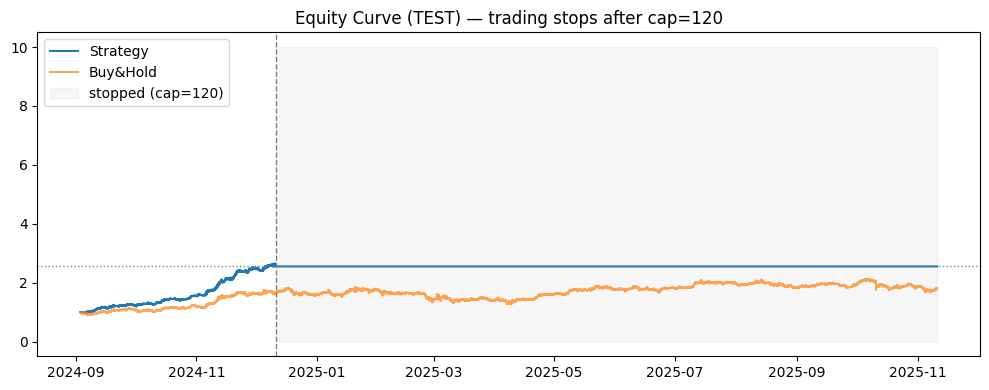

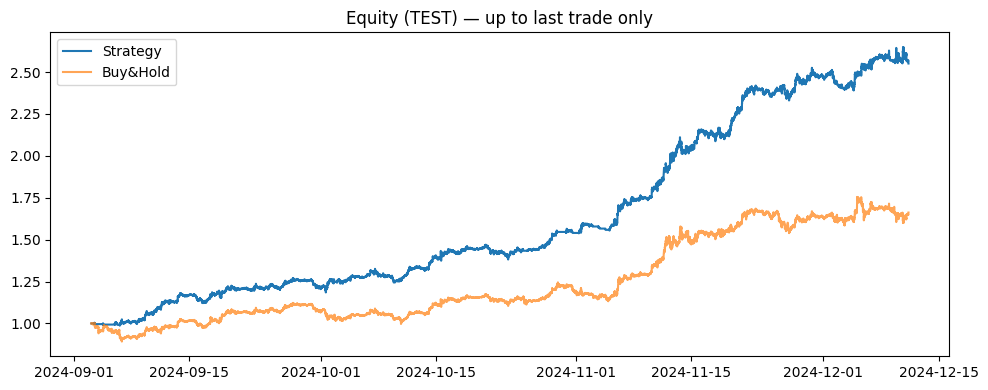

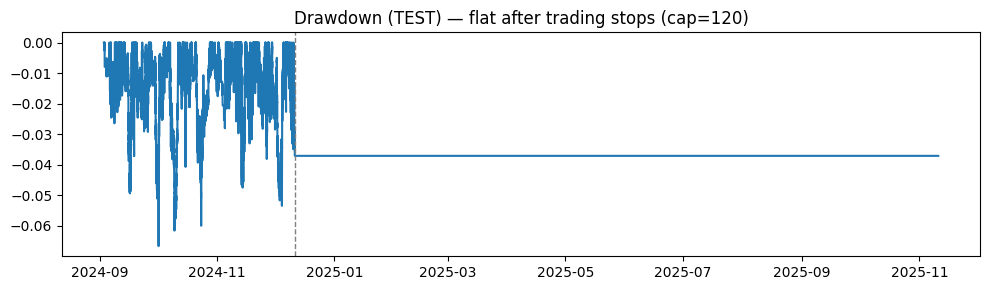

In [26]:
# === add-on: 캡 도달 시점 표시 & 포커스 플롯 ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# trades 포인트 다시 계산 (F1/G1에서 만든 log 사용)
turn = (log["position"].values != np.roll(log["position"].values, 1))
turn[0] = (log["position"].values[0] != 0)
trades_idx = np.where(turn)[0]
last_trade_i = trades_idx[-1] if len(trades_idx)>0 else len(log)-1
last_trade_t = log.loc[last_trade_i, "datetime"]

OUT = Path("/content/runs")

# 1) 전체 구간: cap 도달 이후 영역 음영
plt.figure(figsize=(10,4))
plt.plot(log["datetime"], log["equity"], label="Strategy")
plt.plot(log["datetime"], (log["close"]/log["close"].iloc[0]), label="Buy&Hold", alpha=0.7)
plt.axvline(last_trade_t, color="gray", linewidth=1, linestyle="--")
plt.axhline(log["equity"].iloc[last_trade_i], color="gray", linewidth=1, linestyle=":")
plt.fill_between(log["datetime"], 0, 10, where=log["datetime"]>=last_trade_t,
                 alpha=0.07, color="gray", label="stopped (cap=120)")
plt.title("Equity Curve (TEST) — trading stops after cap=120")
plt.legend(); plt.tight_layout()
plt.savefig(OUT/"equity_vs_bh_cap_annotated.png", dpi=150)

# 2) 포커스: 마지막 거래까지 영역만 확대(보기 좋게)
plt.figure(figsize=(10,4))
mask = log["datetime"] <= last_trade_t
plt.plot(log.loc[mask,"datetime"], log.loc[mask,"equity"], label="Strategy")
plt.plot(log.loc[mask,"datetime"], (log.loc[mask,"close"]/log["close"].iloc[0]), label="Buy&Hold", alpha=0.7)
plt.title("Equity (TEST) — up to last trade only")
plt.legend(); plt.tight_layout()
plt.savefig(OUT/"equity_until_last_trade.png", dpi=150)

# 3) 드로다운도 동일 주석
plt.figure(figsize=(10,3))
plt.plot(log["datetime"], log["drawdown"])
plt.axvline(last_trade_t, color="gray", linestyle="--", linewidth=1)
plt.title("Drawdown (TEST) — flat after trading stops (cap=120)")
plt.tight_layout()
plt.savefig(OUT/"drawdown_cap_annotated.png", dpi=150)

print("Saved annotated figures:",
      "equity_vs_bh_cap_annotated.png, equity_until_last_trade.png, drawdown_cap_annotated.png")

In [27]:
# 핵심 지표 요약 박스
import pandas as pd, numpy as np, matplotlib.pyplot as plt

eq = log["equity"].values
dd = log["drawdown"].values
ret = log["pnl"].values
bh = (log["close"] / log["close"].iloc[0]).values

summary_tbl = pd.DataFrame({
  "Metric":["Net Return","Sharpe","Max Drawdown","Trades"],
  "Strategy":[f"{eq[-1]-1:.2%}",
              f"{(ret.mean()/(ret.std()+1e-12))*np.sqrt(12*24*365):.2f}",
              f"{dd.min():.2%}",
              int((log["position"].values!=np.roll(log["position"].values,1)).sum())],
  "Buy&Hold":[f"{bh[-1]-1:.2%}","—",
              f"{(bh/bh.cummax()-1).min():.2%}","—"]
})
print(summary_tbl.to_string(index=False))

AttributeError: 'numpy.ndarray' object has no attribute 'cummax'

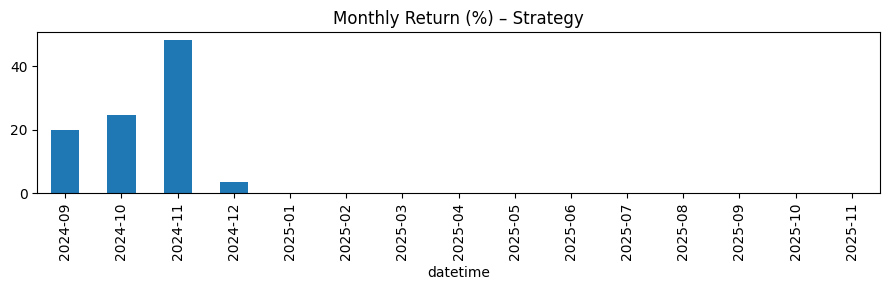

In [28]:
mret = (pd.Series(eq).pct_change().fillna(0)
        .groupby(pd.to_datetime(log["datetime"]).dt.to_period("M")).sum())
plt.figure(figsize=(9,3))
(mret*100).plot(kind="bar")
plt.title("Monthly Return (%) – Strategy")
plt.tight_layout(); plt.savefig(OUT/"monthly_returns.png", dpi=150)


In [9]:
##대책A
# TEST 단독 스캔 (현 모델로 thr/역방향/수수료 전 범위 확인)
best_test = scan_with_constraints(
    proba_te, close_te.values,
    fees=(4.0,6.0,8.0),
    thr_grid=(0.55, 0.70, 61),
    invert_opts=(False, True),
    objective="net_return",
    min_trades=10
)
print("TEST best (any):", best_test)


TEST best (any): {'trades': 40, 'net_return': 0.0006983011969878827, 'sharpe': 0.06601153179334374, 'max_drawdown': -0.00731347379001056, 'final_equity': 1.0006983011969879, 'thr': 0.695, 'fee_bps': 4.0, 'invert': False, 'score': 0.0006983011969878827}


In [10]:
### 대책 B
best_val_robust = scan_with_constraints(
    proba_val, close_val.values,
    fees=(4.0,6.0,8.0),
    thr_grid=(0.56, 0.66, 41),
    invert_opts=(False, True),
    objective="sharpe",   # 또는 "net_return"
    min_trades=30         # 18 -> 30으로 상향 (우연 방지)
)
print("VAL best (robust):", best_val_robust)

bt_robust = backtest_from_proba(
    proba_te, close_te.values,
    thr=best_val_robust["thr"], fee_bps=best_val_robust["fee_bps"], invert=best_val_robust["invert"]
)
print("TEST (apply robust VAL):", bt_robust)

VAL best (robust): {'trades': 60, 'net_return': -0.014487605658415559, 'sharpe': -0.7970349281999815, 'max_drawdown': -0.0228191339423807, 'final_equity': 0.9855123943415844, 'thr': 0.658, 'fee_bps': 4.0, 'invert': True, 'score': -0.7970349281999815}
TEST (apply robust VAL): {'trades': 412, 'net_return': -0.08984637970115084, 'sharpe': -1.6270340588883463, 'max_drawdown': -0.1125599357031606, 'final_equity': 0.9101536202988492}


In [11]:
### 대책 C
def scan_with_caps(proba, close, fees, thrs, invert_opts, objective="sharpe", min_trades=20, max_trades=120):
    best=None
    for inv in invert_opts:
        for f in fees:
            for t in thrs:
                m = backtest_from_proba(proba, close, thr=t, fee_bps=f, invert=inv)
                if m["trades"] < min_trades or m["trades"] > max_trades:
                    continue
                score = m["sharpe"] if objective=="sharpe" else m["net_return"]
                if (best is None) or (score > best["score"]):
                    m.update({"thr": float(t), "fee_bps": float(f), "invert": inv, "score": float(score)})
                    best = m
    return best

thrs = np.round(np.linspace(0.56, 0.66, 41), 3)
best_val_cap = scan_with_caps(proba_val, close_val.values, (4.0,6.0,8.0), thrs, (False,True),
                              objective="sharpe", min_trades=30, max_trades=120)
print("VAL best (cap):", best_val_cap)

bt_cap = backtest_from_proba(proba_te, close_te.values, thr=best_val_cap["thr"],
                             fee_bps=best_val_cap["fee_bps"], invert=best_val_cap["invert"])
print("TEST (VAL-cap):", bt_cap)

VAL best (cap): {'trades': 60, 'net_return': -0.014487605658415559, 'sharpe': -0.7970349281999815, 'max_drawdown': -0.0228191339423807, 'final_equity': 0.9855123943415844, 'thr': 0.658, 'fee_bps': 4.0, 'invert': True, 'score': -0.7970349281999815}
TEST (VAL-cap): {'trades': 412, 'net_return': -0.08984637970115084, 'sharpe': -1.6270340588883463, 'max_drawdown': -0.1125599357031606, 'final_equity': 0.9101536202988492}
